<a href="https://colab.research.google.com/github/meichenfang/Poisson-regression/blob/main/find-weight.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

**Denote the gene expression matrix by $X_{ij}$ where j is gene index and i is cell index. In summary, we assume a specific model of transcription and want to solve**

\begin{align}
    & \text{argmax}_{\theta_j} \sum_{j} \sum_i \ln P(\mathcal{X}_{ij},t_i; \theta_j,\tau).
\end{align}

We assume t follows a uniform distribution on [0,1]. We use alternative minimization/EM-like algorithm to find optimal θ.

In [38]:
import time
%cd functions
from EM_functions_single import *
from MC_functions import *
%cd ..

/home/mffang/workspace/RNAV/Poisson-regression/functions
/home/mffang/workspace/RNAV/Poisson-regression


In [39]:
def plot_t(weight,ax=None,t=None):
    m=np.shape(weight)[1]
    h=np.linspace(0,1,m)
    t_hat=np.sum(weight*h[None,:],axis=1)
    if ax is None:
        fig, ax = plt.subplots(1,1)
    if t is not None:
        ord=np.argsort(t)
        # build a rectangle in axes coords
        left, width = .25, .5
        bottom, height = .25, .5
        right = left + width
        top = bottom + height
       
        ax.imshow(weight[ord,:],aspect="auto");
        ax.text(right, top,"cor="+str(np.around(np.corrcoef(t_hat,t)[0,1],2)), horizontalalignment='right', 
                 verticalalignment='top', transform=ax.transAxes, color="white");
    else:
        ord=np.argsort(t_hat)
        ax.imshow(weight[ord,:],aspect="auto");

def plot_theta_hat(theta_hat,K,gene_list=None):
    if gene_list is None:
        gene_list = np.arange(len(theta_hat))
    fig, ax = plt.subplots(K+4,1,figsize=(12,4*(K+4)))
    ax[0].scatter(np.array(gene_list), theta_hat[:,0]);
    ax[-3].scatter(np.array(gene_list), theta_hat[:,-3]);
    for i in range(1,K+1):
        ax[i].scatter(np.array(gene_list), theta_hat[:,i]-theta_hat[:,0]);
        
    for i in range(-2,0):
        ax[i].scatter(np.array(gene_list), theta_hat[:,i]);

    ax[0].set_title("a1");
    ax[1].set_title("a2 - a1");
    ax[2].set_title("u0 - a1");
    ax[3].set_title("s0");
    ax[4].set_title("beta");
    ax[5].set_title("gamma");


def plot_y(X,theta_hat,weight,tau,gene_list):
    m=np.shape(weight)[1]
    p=np.shape(theta_hat)[0]
    h=np.linspace(0,1,m)
    t_hat=np.sum(weight*h[None,:],axis=1)
    y_hat = get_Y(theta_hat, t_hat, tau)
    fig, ax = plt.subplots(2,p,figsize=(6*p,8))
    if p==1:
        i=0
        ax[0].scatter(t_hat,X[:,i,0],c=colors20[np.mod(clusters, 20)]);
        ax[0].plot(t_hat,y_hat[:,i,0],'r.');
        ax[0].set_title(gene_list[0]+" unspliced")

        ax[1].scatter(t_hat,X[:,i,1],c=colors20[np.mod(clusters, 20)]);
        ax[1].plot(t_hat,y_hat[:,i,1],'r.');
        ax[1].set_title(gene_list[0]+" spliced")
    else:
        for i in range(p):
            ax[0,i].scatter(t_hat,X[:,i,0],c=colors20[np.mod(clusters, 20)]);
            ax[0,i].plot(t_hat,y_hat[:,i,0],'r.');
            ax[0,i].set_title(gene_list[i]+" unspliced")

            ax[1,i].scatter(t_hat,X[:,i,1],c=colors20[np.mod(clusters, 20)]);
            ax[1,i].plot(t_hat,y_hat[:,i,1],'r.');
            ax[1,i].set_title(gene_list[i]+" spliced")

            
            
def plot_phase(X,theta_hat,weight,tau,gene_list):
    m=np.shape(weight)[1]
    p=np.shape(theta_hat)[0]
    h=np.linspace(0,1,m)
    t_hat=np.sum(weight*h[None,:],axis=1)
    y_hat = get_Y(theta_hat, t_hat, tau)
    fig, ax = plt.subplots(1,p,figsize=(6*p,4))
    if p==1:
        i=0
        ax.scatter(X[:,i,0],X[:,i,1],c=colors20[np.mod(clusters, 20)]);
        ax.scatter(y_hat[:,i,0],y_hat[:,i,1],c=t_hat);
        ax.set_title(gene_list[0])

    else:
        for i in range(p):
            ax[i].scatter(X[:,i,0],X[:,i,1],c=colors20[np.mod(clusters, 20)]);
            ax[i].scatter(y_hat[:,i,0],y_hat[:,i,1],c=t_hat);
            ax[i].set_title(gene_list[i])
            

# Real data

In [40]:
import scanpy

adata = scanpy.read('data/hgForebrainGlut.loom')
adata.var_names_make_unique
adata

/home/mffang/miniconda3/envs/main/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 1720 × 32738
    obs: 'Clusters'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    layers: 'matrix', 'ambiguous', 'spliced', 'unspliced'

**Read clusters information**

In [41]:
clusters = adata.obs["Clusters"]
Clusters = set(clusters)
print(Clusters)
colors20 = np.vstack((plt.cm.tab20b(np.linspace(0., 1, 20))[::2], plt.cm.tab20c(np.linspace(0, 1, 20))[1::2]))

{0, 1, 2, 3, 4, 5, 6}


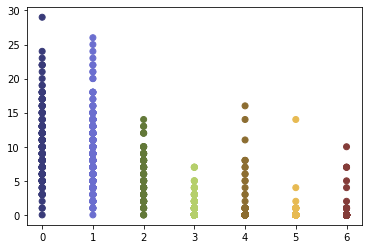

In [42]:
gene=["SOX2"]
idx=adata.var_names.isin(gene)
u=adata.layers["unspliced"][:,idx].toarray()
s=adata.layers["spliced"][:,idx].toarray()
plt.scatter(clusters,s, c=colors20[np.mod(clusters, 20)])

**Initiate weight using clusters**

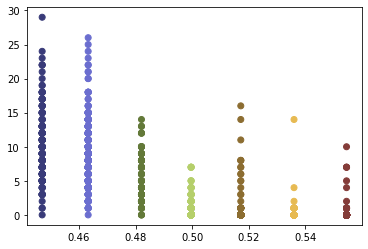

In [43]:
m=172
t_grids=np.linspace(0,1,m)
weight0 = np.ones((adata.n_obs,m))
for i in Clusters:
    idx = clusters.isin([i])
    weight0[idx,int(i*m/7):int((i+1)*m/7)] += 1
weight0=weight0/weight0.sum(axis=1,keepdims=True)
plt.scatter(np.sum(t_grids[None,:]*weight0,axis=1),s,c=colors20[np.mod(clusters, 20)]);

## Inference with only marker genes

In [44]:
marker_genes=["SOX2","SLC17A7","EOMES","CLU","FBXO32",
       "UNC5D","SEZ6","RBFOX1","DCX","GRIA3",
       "STMN2", "FAM64A","ELAVL4","RNASEH2B"]
marker_idx=adata.var_names.isin(marker_genes)
gene_list=adata.var_names[marker_idx]
u=adata.layers["unspliced"][:,marker_idx].toarray()
s=adata.layers["spliced"][:,marker_idx].toarray()
n,p=np.shape(s)
X=np.zeros((n,p,2))
X[:,:,0]=u
X[:,:,1]=s

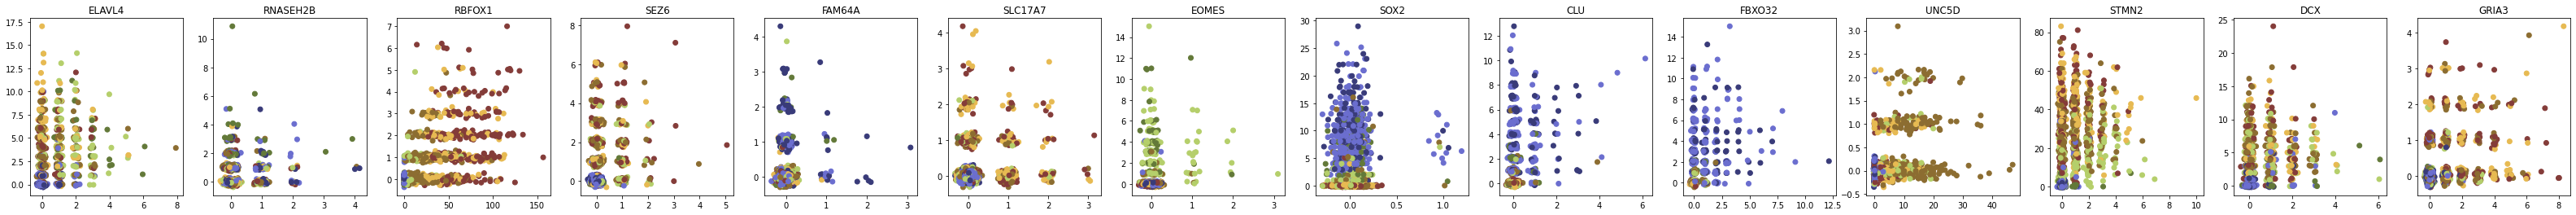

In [45]:
fig, ax = plt.subplots(1,14,figsize=(4*14,4))
for j in range(14):
    ax[j].scatter(X[:,j,0]+np.random.normal(scale=0.1,size=n),X[:,j,1]+np.random.normal(scale=0.1,size=n),c=colors20[np.mod(clusters, 20)]);
    ax[j].set_title(gene_list[j]);

### One state

In [9]:
tau=(0,1)
theta_hat_hist, weight_hist = traj_EM(X,tau=tau, weight0=weight0, epoch=10, parallel=True, n_threads=min(p,10))
theta_hat_m = theta_hat_hist[-1]
weight_m = weight_hist[-1]

100%|██████████| 10/10 [01:02<00:00,  6.21s/it]


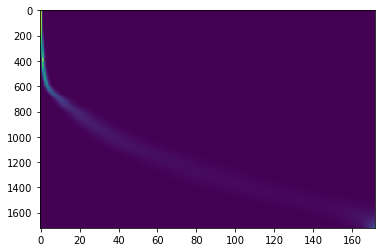

In [10]:
plot_t(weight_m)

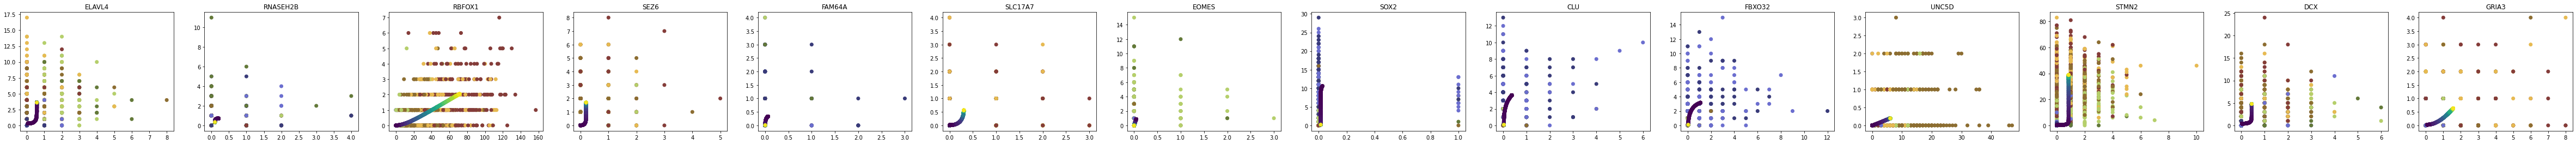

In [11]:
plot_phase(X,theta_hat_m,weight_m,tau,gene_list)

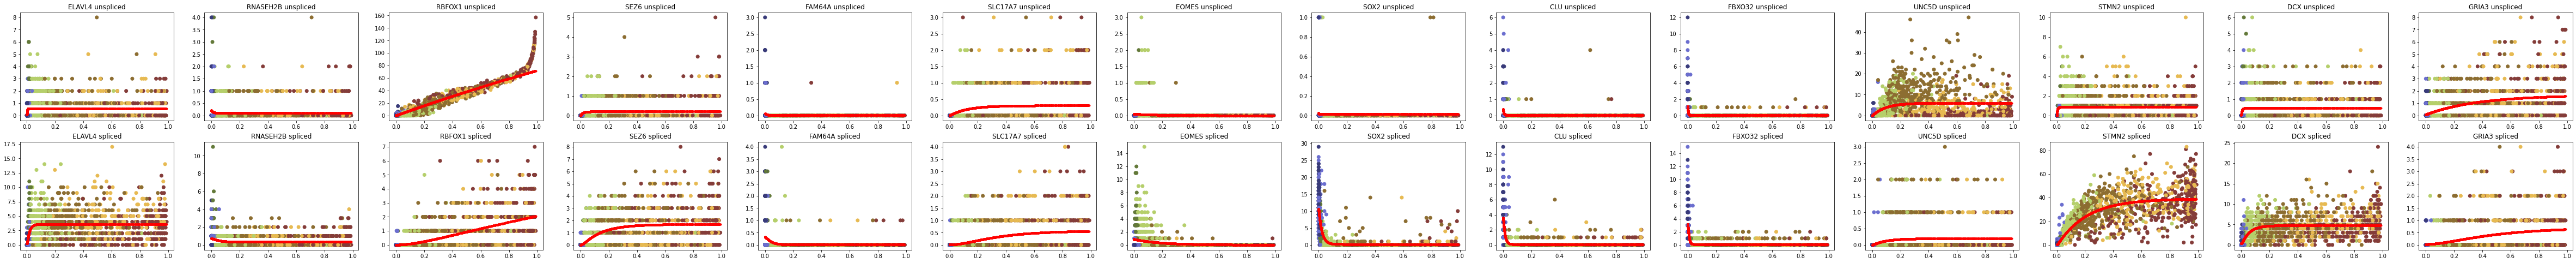

In [12]:
plot_y(X,theta_hat_m,weight_m,tau,gene_list)

### Two states 0.5

In [46]:
tau=(0,0.5,1)

In [47]:
theta_hat_hist, weight_hist = traj_EM(X,tau=(0,0.5,1), weight0=weight0, epoch=10, parallel=True, n_threads=min(p,10))
theta_hat_m = theta_hat_hist[-1]
weight_m = weight_hist[-1]

100%|██████████| 10/10 [01:08<00:00,  6.85s/it]


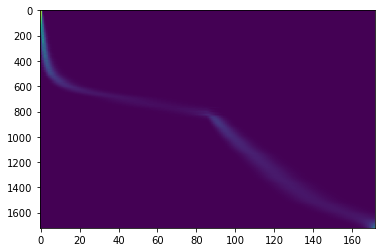

In [48]:
plot_t(weight_m)

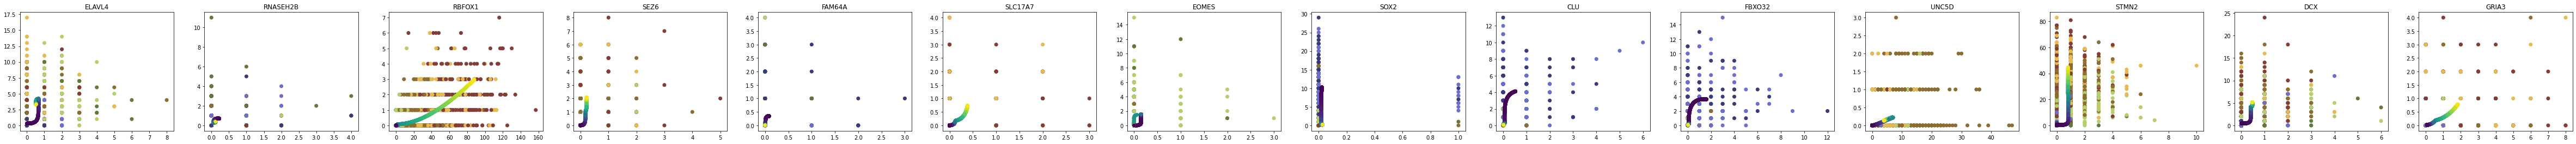

In [49]:
plot_phase(X,theta_hat_m,weight_m,tau,gene_list)

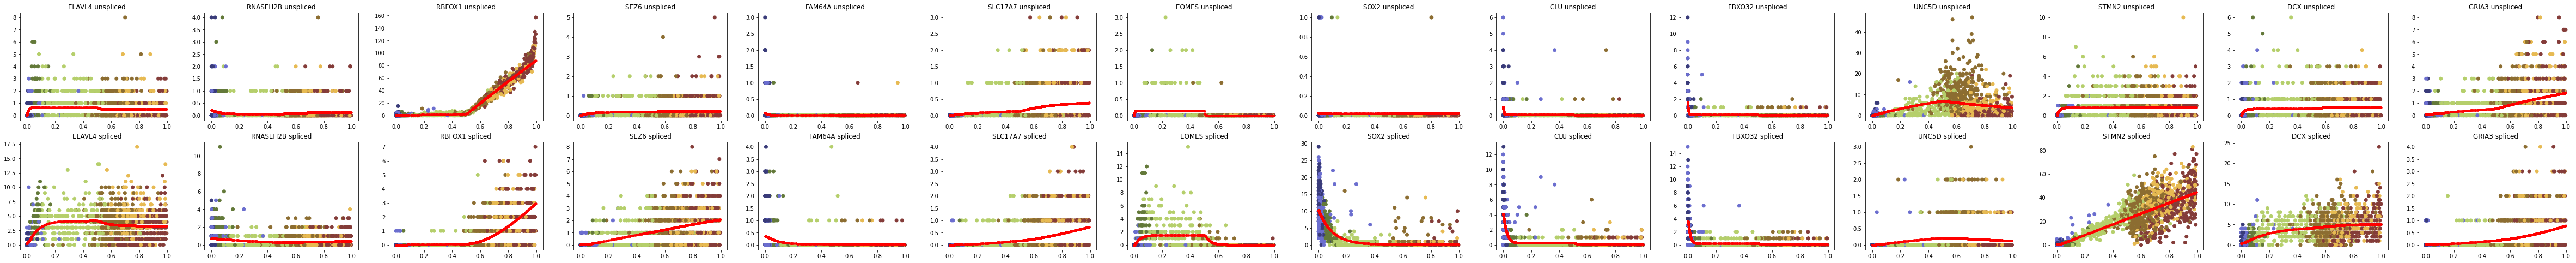

In [50]:
plot_y(X,theta_hat_m,weight_m,tau,gene_list)

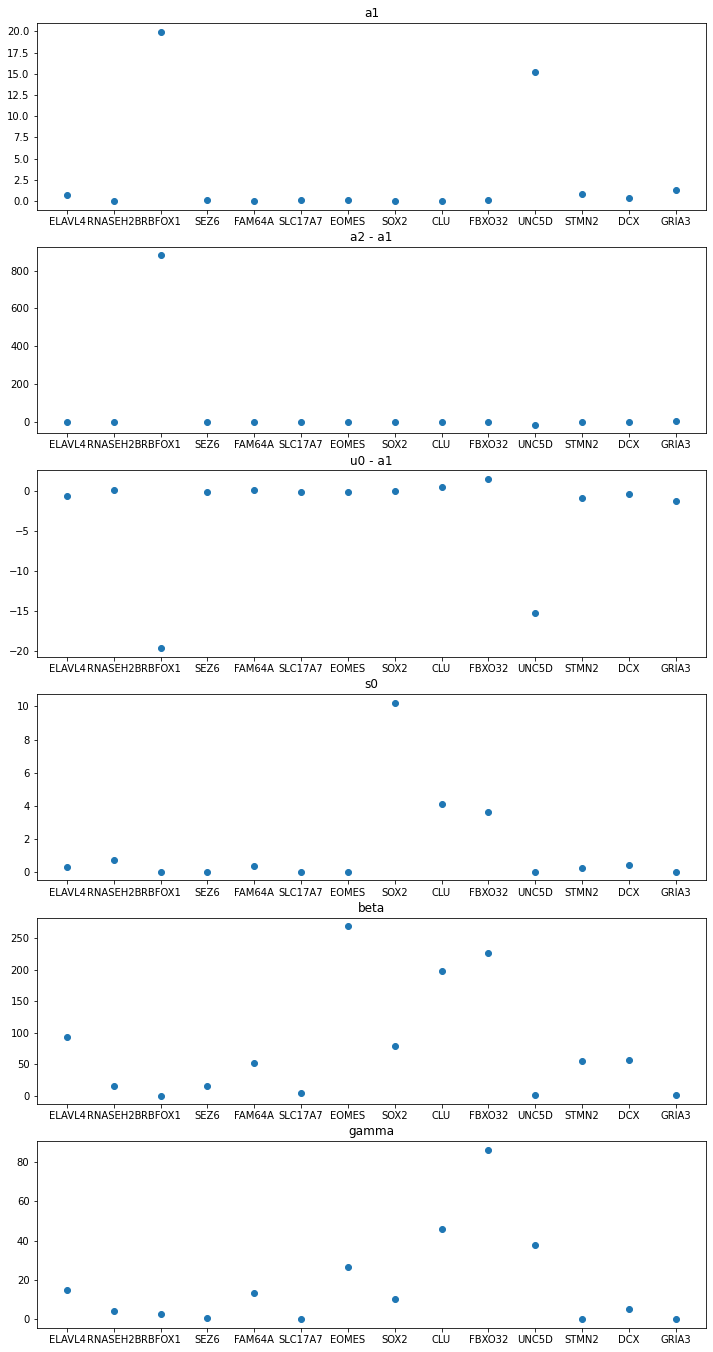

In [18]:
plot_theta_hat(theta_hat_m, len(tau)-1, gene_list)

**Check cell size** 

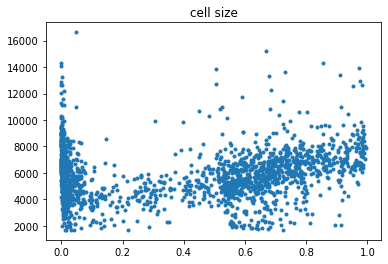

In [16]:
weight=weight_hist[-1]
m=np.shape(weight)[1]
h=np.linspace(0,1,m)
t_hat=np.sum(weight*h[None,:],axis=1)
plt.plot(t_hat,np.sum(adata.layers["spliced"],axis=1),'.');
plt.title("cell size");

# Use many non poisson genes

## Case 1

In [66]:
U=adata.layers["unspliced"][:,:].toarray()
S=adata.layers["spliced"][:,:].toarray()

/tmp/ipykernel_28669/4258415493.py:6: RuntimeWarning: invalid value encountered in true_divide
  idx=( ((U_mu>2) &  ((U_var/U_mu-1)/U_mu>0.5)) | ((S_mu>4) & ((S_var/S_mu-1)/S_mu>0.2)) ) | marker_idx
/tmp/ipykernel_28669/4258415493.py:10: RuntimeWarning: divide by zero encountered in log
  axs[0].plot(np.log(U_mu),np.log(U_var),'.');
/tmp/ipykernel_28669/4258415493.py:11: RuntimeWarning: divide by zero encountered in log
  axs[0].plot(np.log(U_mu[idx]),np.log(U_var[idx]),'r.');
/tmp/ipykernel_28669/4258415493.py:12: RuntimeWarning: divide by zero encountered in log
  axs[0].plot(np.log(U_mu),np.log(U_mu));
/tmp/ipykernel_28669/4258415493.py:14: RuntimeWarning: divide by zero encountered in log
  axs[1].plot(np.log(S_mu),np.log(S_var),'.');
/tmp/ipykernel_28669/4258415493.py:16: RuntimeWarning: divide by zero encountered in log
  axs[1].plot(np.log(S_mu),np.log(S_mu));


178


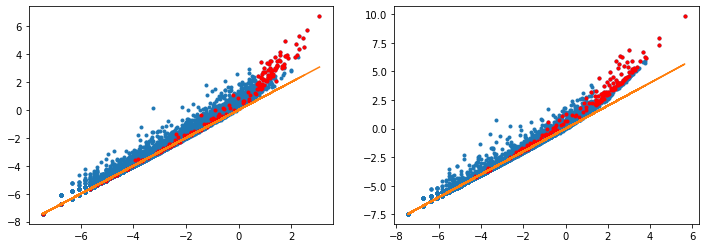

In [51]:
U_mu = np.mean(U,axis=0)
U_var = np.mean((U-U_mu[None,:])**2,axis=0)
S_mu = np.mean(S,axis=0)
S_var = np.mean((S-S_mu[None,:])**2,axis=0)

idx=( ((U_mu>2) &  ((U_var/U_mu-1)/U_mu>0.5)) | ((S_mu>4) & ((S_var/S_mu-1)/S_mu>0.2)) ) | marker_idx
print(np.sum(idx))

fig, axs = plt.subplots(1,2,figsize=(12,4))
axs[0].plot(np.log(U_mu),np.log(U_var),'.');
axs[0].plot(np.log(U_mu[idx]),np.log(U_var[idx]),'r.');
axs[0].plot(np.log(U_mu),np.log(U_mu));

axs[1].plot(np.log(S_mu),np.log(S_var),'.');
axs[1].plot(np.log(S_mu[idx]),np.log(S_var[idx]),'r.');
axs[1].plot(np.log(S_mu),np.log(S_mu));

/tmp/ipykernel_28669/100938405.py:2: RuntimeWarning: divide by zero encountered in log
  axs[0].plot(np.log(U_mu),np.log(U_var),'.');
/tmp/ipykernel_28669/100938405.py:4: RuntimeWarning: divide by zero encountered in log
  axs[0].plot(np.log(U_mu),np.log(U_mu));
/tmp/ipykernel_28669/100938405.py:6: RuntimeWarning: divide by zero encountered in log
  axs[1].plot(np.log(S_mu),np.log(S_var),'.');
/tmp/ipykernel_28669/100938405.py:8: RuntimeWarning: divide by zero encountered in log
  axs[1].plot(np.log(S_mu),np.log(S_mu));


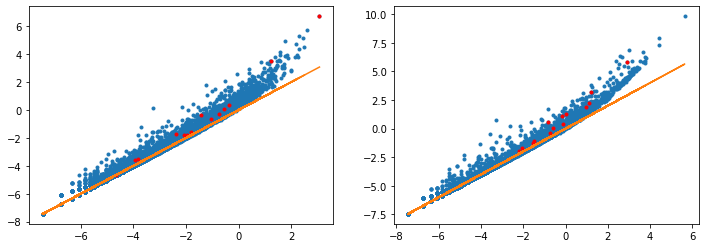

In [52]:
fig, axs = plt.subplots(1,2,figsize=(12,4))
axs[0].plot(np.log(U_mu),np.log(U_var),'.');
axs[0].plot(np.log(U_mu[marker_idx]),np.log(U_var[marker_idx]),'r.');
axs[0].plot(np.log(U_mu),np.log(U_mu));

axs[1].plot(np.log(S_mu),np.log(S_var),'.');
axs[1].plot(np.log(S_mu[marker_idx]),np.log(S_var[marker_idx]),'r.');
axs[1].plot(np.log(S_mu),np.log(S_mu));

In [53]:
gene_list=adata.var_names[idx]
u=adata.layers["unspliced"][:,idx].toarray()
s=adata.layers["spliced"][:,idx].toarray()
n,p=np.shape(s)
X=np.zeros((n,p,2))
X[:,:,0]=u
X[:,:,1]=s

In [54]:
plot_idx = gene_list.isin(marker_genes)
gene_list[plot_idx]

Index(['ELAVL4', 'RNASEH2B', 'RBFOX1', 'SEZ6', 'FAM64A', 'SLC17A7', 'EOMES',
       'SOX2', 'CLU', 'FBXO32', 'UNC5D', 'STMN2', 'DCX', 'GRIA3'],
      dtype='object', name='Gene')

In [ ]:
theta_hat_hist, weight_hist = traj_EM(X,tau=(0,0.5,1),weight0=weight0, epoch=10, parallel=True, n_threads=min(p,20))

 40%|████      | 4/10 [06:22<08:48, 88.10s/it] 

In [55]:
theta_hat_1 = theta_hat_hist[-1]
weight_1 = weight_hist[-1]

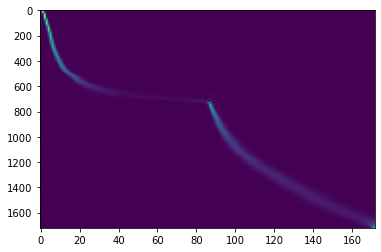

In [56]:
plot_t(weight_1)

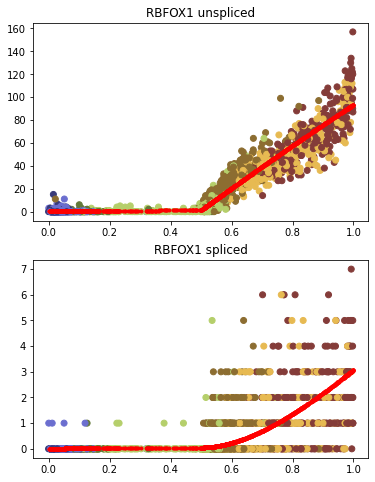

In [71]:
plot_y(X[:,plot_idx,:],theta_hat_1[plot_idx,:], weight_1, tau, gene_list[plot_idx])

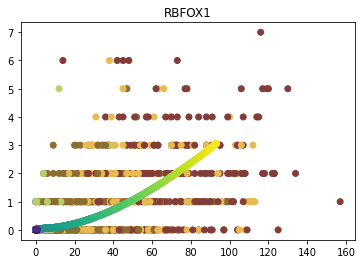

In [62]:
plot_phase(X[:,plot_idx,:],theta_hat_1[plot_idx,:], weight_1, tau, gene_list[plot_idx])

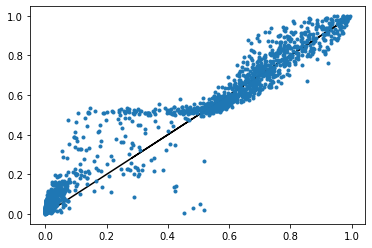

In [97]:
h=np.linspace(0,1,m)
t_m=np.sum(weight_m*h[None,:],axis=1)
t_1=np.sum(weight_1*h[None,:],axis=1)
plt.plot(t_m,t_m,'black');
plt.plot(t_m,t_1,'.');

## Case 2

50


/tmp/ipykernel_9473/2678500394.py:9: RuntimeWarning: invalid value encountered in true_divide
  idx=( ((U_mu>4) &  ((U_var/U_mu-1)/U_mu>0.5)) | ((S_mu>4) & ((S_var/S_mu-1)/S_mu>0.5)) )
/tmp/ipykernel_9473/2678500394.py:13: RuntimeWarning: divide by zero encountered in log
  axs[0].plot(np.log(U_mu),np.log(U_var),'.');
/tmp/ipykernel_9473/2678500394.py:14: RuntimeWarning: divide by zero encountered in log
  axs[0].plot(np.log(U_mu[idx]),np.log(U_var[idx]),'r.');
/tmp/ipykernel_9473/2678500394.py:15: RuntimeWarning: divide by zero encountered in log
  axs[0].plot(np.log(U_mu),np.log(U_mu));
/tmp/ipykernel_9473/2678500394.py:17: RuntimeWarning: divide by zero encountered in log
  axs[1].plot(np.log(S_mu),np.log(S_var),'.');
/tmp/ipykernel_9473/2678500394.py:19: RuntimeWarning: divide by zero encountered in log
  axs[1].plot(np.log(S_mu),np.log(S_mu));


Index(['RBFOX1', 'STMN2'], dtype='object', name='Gene')

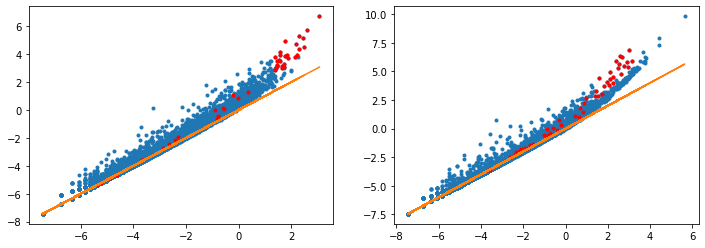

In [87]:
U=adata.layers["unspliced"][:,:].toarray()
S=adata.layers["spliced"][:,:].toarray()

U_mu = np.mean(U,axis=0)
U_var = np.mean((U-U_mu[None,:])**2,axis=0)
S_mu = np.mean(S,axis=0)
S_var = np.mean((S-S_mu[None,:])**2,axis=0)

idx=( ((U_mu>4) &  ((U_var/U_mu-1)/U_mu>0.5)) | ((S_mu>4) & ((S_var/S_mu-1)/S_mu>0.5)) )
print(np.sum(idx))

fig, axs = plt.subplots(1,2,figsize=(12,4))
axs[0].plot(np.log(U_mu),np.log(U_var),'.');
axs[0].plot(np.log(U_mu[idx]),np.log(U_var[idx]),'r.');
axs[0].plot(np.log(U_mu),np.log(U_mu));

axs[1].plot(np.log(S_mu),np.log(S_var),'.');
axs[1].plot(np.log(S_mu[idx]),np.log(S_var[idx]),'r.');
axs[1].plot(np.log(S_mu),np.log(S_mu));

gene_list=adata.var_names[idx]
u=adata.layers["unspliced"][:,idx].toarray()
s=adata.layers["spliced"][:,idx].toarray()
n,p=np.shape(s)
X=np.zeros((n,p,2))
X[:,:,0]=u
X[:,:,1]=s

plot_idx = gene_list.isin(marker_genes)
gene_list[plot_idx]

In [89]:
theta_hat_hist, weight_hist = traj_EM(X,tau=(0,0.5,1), weight0=weight0, epoch=20, parallel=True, n_threads=min(p,5))
theta_hat_2 = theta_hat_hist[-1]
weight_2 = weight_hist[-1]

100%|██████████| 20/20 [08:20<00:00, 25.05s/it]


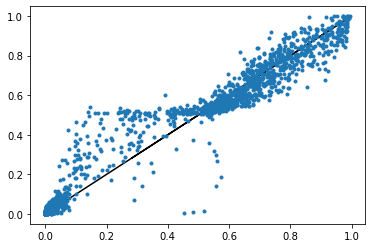

In [96]:
h=np.linspace(0,1,m)
t_m=np.sum(weight_m*h[None,:],axis=1)
t_2=np.sum(weight_2*h[None,:],axis=1)
plt.plot(t_m,t_m,'black');
plt.plot(t_m,t_2,'.');

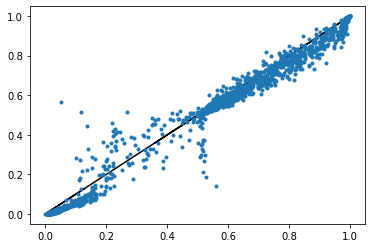

In [95]:
plt.plot(t_1,t_1,'black');
plt.plot(t_1,t_2,'.');

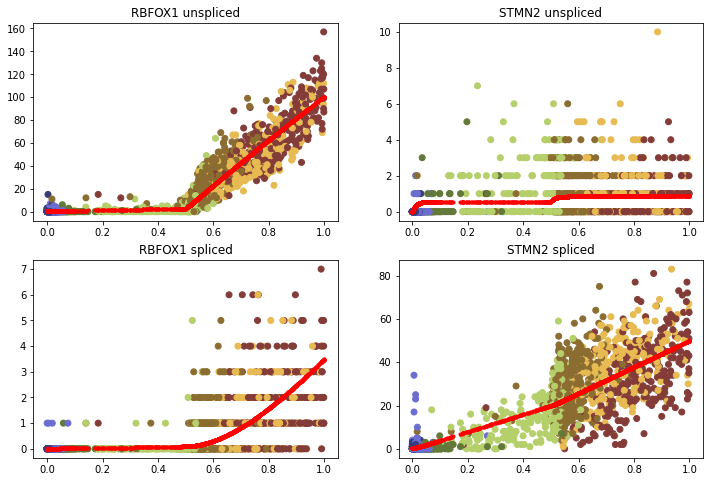

In [93]:
plot_y(X[:,plot_idx,:],theta_hat_2[plot_idx,:], weight_2, tau, gene_list[plot_idx])

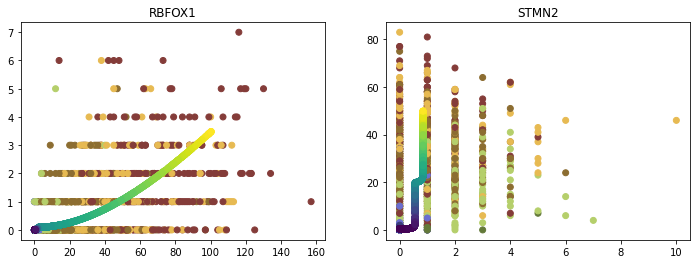

In [92]:
plot_phase(X[:,plot_idx,:],theta_hat_2[plot_idx,:], weight_2, tau, gene_list[plot_idx])

## Case 3

167


/tmp/ipykernel_9473/1622870795.py:9: RuntimeWarning: invalid value encountered in true_divide
  idx=( ((U_mu>2) &  ((U_var/U_mu-1)/U_mu>0.5)) | ((S_mu>4) & ((S_var/S_mu-1)/S_mu>0.2)) )
/tmp/ipykernel_9473/1622870795.py:13: RuntimeWarning: divide by zero encountered in log
  axs[0].plot(np.log(U_mu),np.log(U_var),'.');
/tmp/ipykernel_9473/1622870795.py:14: RuntimeWarning: divide by zero encountered in log
  axs[0].plot(np.log(U_mu[idx]),np.log(U_var[idx]),'r.');
/tmp/ipykernel_9473/1622870795.py:15: RuntimeWarning: divide by zero encountered in log
  axs[0].plot(np.log(U_mu),np.log(U_mu));
/tmp/ipykernel_9473/1622870795.py:17: RuntimeWarning: divide by zero encountered in log
  axs[1].plot(np.log(S_mu),np.log(S_var),'.');
/tmp/ipykernel_9473/1622870795.py:19: RuntimeWarning: divide by zero encountered in log
  axs[1].plot(np.log(S_mu),np.log(S_mu));


Index(['RBFOX1', 'UNC5D', 'STMN2'], dtype='object', name='Gene')

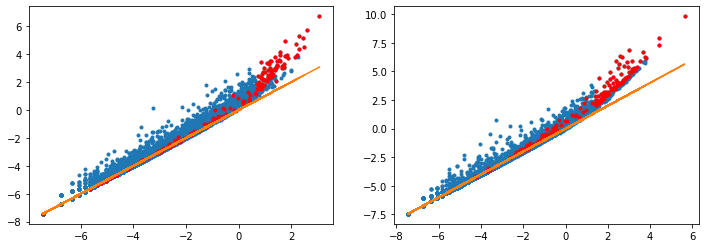

In [103]:
U=adata.layers["unspliced"][:,:].toarray()
S=adata.layers["spliced"][:,:].toarray()

U_mu = np.mean(U,axis=0)
U_var = np.mean((U-U_mu[None,:])**2,axis=0)
S_mu = np.mean(S,axis=0)
S_var = np.mean((S-S_mu[None,:])**2,axis=0)

idx=( ((U_mu>2) &  ((U_var/U_mu-1)/U_mu>0.5)) | ((S_mu>4) & ((S_var/S_mu-1)/S_mu>0.2)) )
print(np.sum(idx))

fig, axs = plt.subplots(1,2,figsize=(12,4))
axs[0].plot(np.log(U_mu),np.log(U_var),'.');
axs[0].plot(np.log(U_mu[idx]),np.log(U_var[idx]),'r.');
axs[0].plot(np.log(U_mu),np.log(U_mu));

axs[1].plot(np.log(S_mu),np.log(S_var),'.');
axs[1].plot(np.log(S_mu[idx]),np.log(S_var[idx]),'r.');
axs[1].plot(np.log(S_mu),np.log(S_mu));

gene_list=adata.var_names[idx]
u=adata.layers["unspliced"][:,idx].toarray()
s=adata.layers["spliced"][:,idx].toarray()
n,p=np.shape(s)
X=np.zeros((n,p,2))
X[:,:,0]=u
X[:,:,1]=s

plot_idx = gene_list.isin(marker_genes)
gene_list[plot_idx]

In [104]:
theta_hat_hist, weight_hist = traj_EM(X,tau=(0,0.5,1), weight0=weight0, epoch=20, parallel=True, n_threads=min(p,10))
theta_hat_3 = theta_hat_hist[-1]
weight_3 = weight_hist[-1]

100%|██████████| 20/20 [18:13<00:00, 54.69s/it]


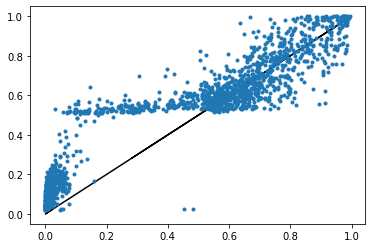

In [105]:
t_3=np.sum(weight_3*h[None,:],axis=1)
plt.plot(t_m,t_m,'black');
plt.plot(t_m,t_3,'.');

(array([358., 221.,  29.,   8.,  12., 466., 242., 143., 115., 126.]),
 array([0.01754386, 0.11578387, 0.21402389, 0.3122639 , 0.41050391,
        0.50874393, 0.60698394, 0.70522396, 0.80346397, 0.90170398,
        0.999944  ]),
 <BarContainer object of 10 artists>)

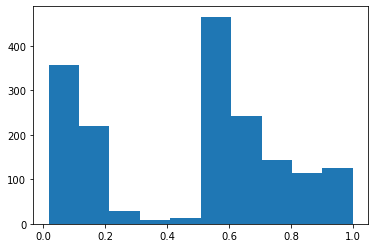

In [110]:
plt.hist(t_3)

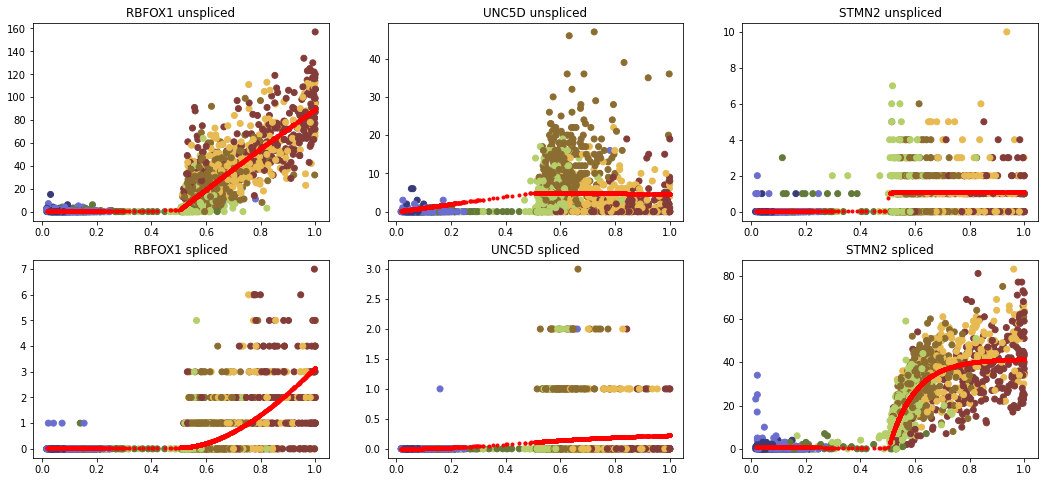

In [106]:
plot_y(X[:,plot_idx,:],theta_hat_3[plot_idx,:], weight_3, tau, gene_list[plot_idx])

## Case 4

275


/tmp/ipykernel_28669/3895528507.py:9: RuntimeWarning: invalid value encountered in true_divide
  idx=( ((U_mu>2) &  ((U_var/U_mu-1)/U_mu>0.5)) | ((S_mu>2) & ((S_var/S_mu-1)/S_mu>0.2)) )
/tmp/ipykernel_28669/3895528507.py:13: RuntimeWarning: divide by zero encountered in log
  axs[0].plot(np.log(U_mu),np.log(U_var),'.');
/tmp/ipykernel_28669/3895528507.py:14: RuntimeWarning: divide by zero encountered in log
  axs[0].plot(np.log(U_mu[idx]),np.log(U_var[idx]),'r.');
/tmp/ipykernel_28669/3895528507.py:15: RuntimeWarning: divide by zero encountered in log
  axs[0].plot(np.log(U_mu),np.log(U_mu));
/tmp/ipykernel_28669/3895528507.py:17: RuntimeWarning: divide by zero encountered in log
  axs[1].plot(np.log(S_mu),np.log(S_var),'.');
/tmp/ipykernel_28669/3895528507.py:19: RuntimeWarning: divide by zero encountered in log
  axs[1].plot(np.log(S_mu),np.log(S_mu));


Index(['ELAVL4', 'RBFOX1', 'SOX2', 'UNC5D', 'STMN2', 'DCX'], dtype='object', name='Gene')

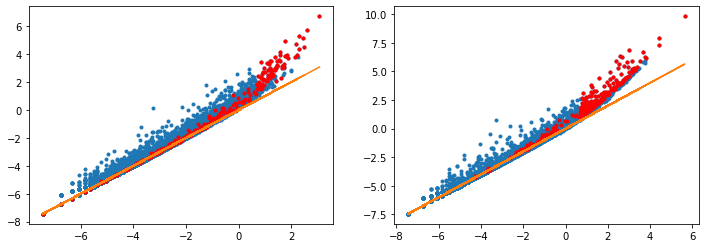

In [35]:
U=adata.layers["unspliced"][:,:].toarray()
S=adata.layers["spliced"][:,:].toarray()

U_mu = np.mean(U,axis=0)
U_var = np.mean((U-U_mu[None,:])**2,axis=0)
S_mu = np.mean(S,axis=0)
S_var = np.mean((S-S_mu[None,:])**2,axis=0)

idx=( ((U_mu>2) &  ((U_var/U_mu-1)/U_mu>0.5)) | ((S_mu>2) & ((S_var/S_mu-1)/S_mu>0.2)) )
print(np.sum(idx))

fig, axs = plt.subplots(1,2,figsize=(12,4))
axs[0].plot(np.log(U_mu),np.log(U_var),'.');
axs[0].plot(np.log(U_mu[idx]),np.log(U_var[idx]),'r.');
axs[0].plot(np.log(U_mu),np.log(U_mu));

axs[1].plot(np.log(S_mu),np.log(S_var),'.');
axs[1].plot(np.log(S_mu[idx]),np.log(S_var[idx]),'r.');
axs[1].plot(np.log(S_mu),np.log(S_mu));

gene_list=adata.var_names[idx]
u=adata.layers["unspliced"][:,idx].toarray()
s=adata.layers["spliced"][:,idx].toarray()
n,p=np.shape(s)
X=np.zeros((n,p,2))
X[:,:,0]=u
X[:,:,1]=s

plot_idx = gene_list.isin(marker_genes)
gene_list[plot_idx] 

In [27]:
theta_hat_hist, weight_hist = traj_EM(X,tau=(0,0.5,1), weight0=weight0, epoch=10, parallel=True, n_threads=min(p,10))
theta_hat_4 = theta_hat_hist[-1]
weight_4 = weight_hist[-1]

100%|██████████| 10/10 [19:23<00:00, 116.37s/it]


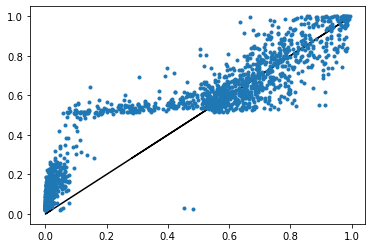

In [20]:
h=np.linspace(0,1,m)
t_m=np.sum(weight_m*h[None,:],axis=1)
t_4=np.sum(weight_4*h[None,:],axis=1)
plt.plot(t_m,t_m,'black');
plt.plot(t_m,t_4,'.');

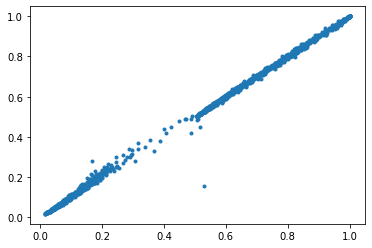

In [123]:
plt.plot(t_3,t_4,'.');

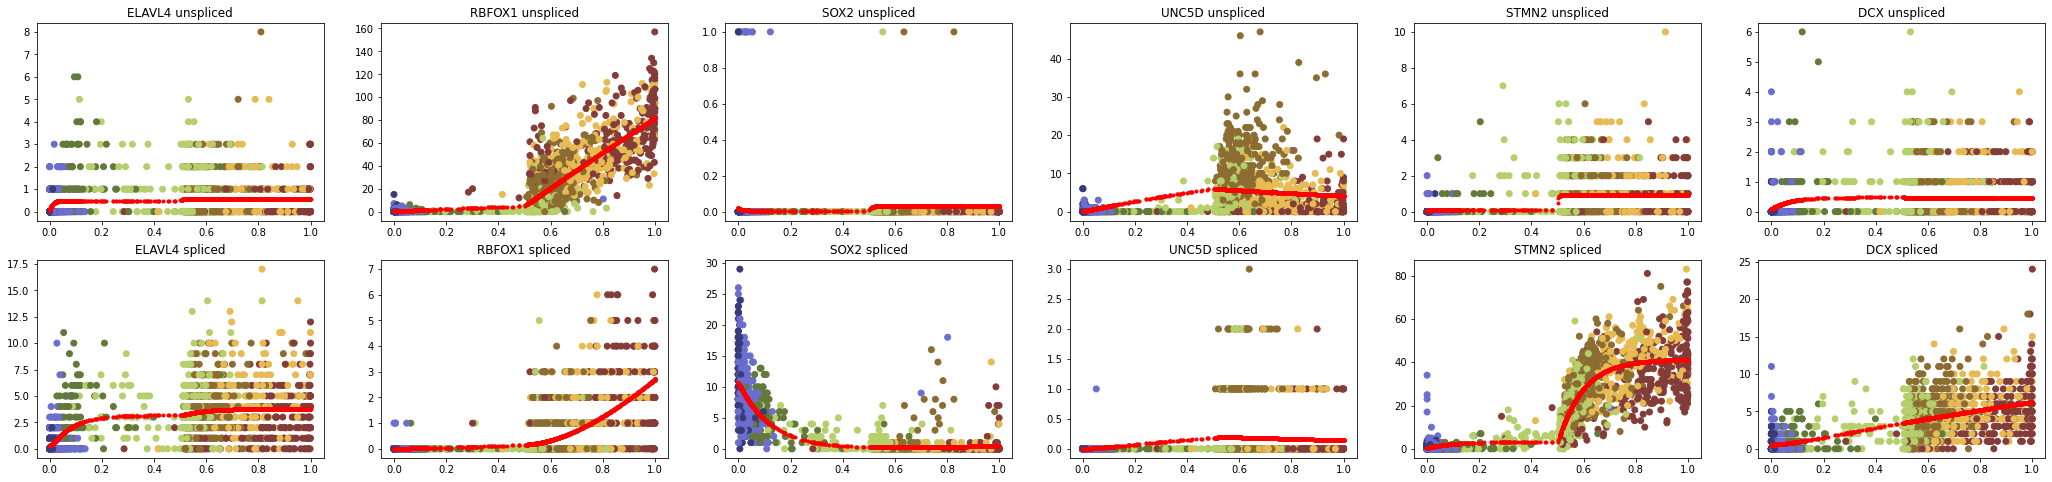

In [36]:
plot_y(X[:,plot_idx,:],theta_hat_4[plot_idx,:], weight_4, tau, gene_list[plot_idx])

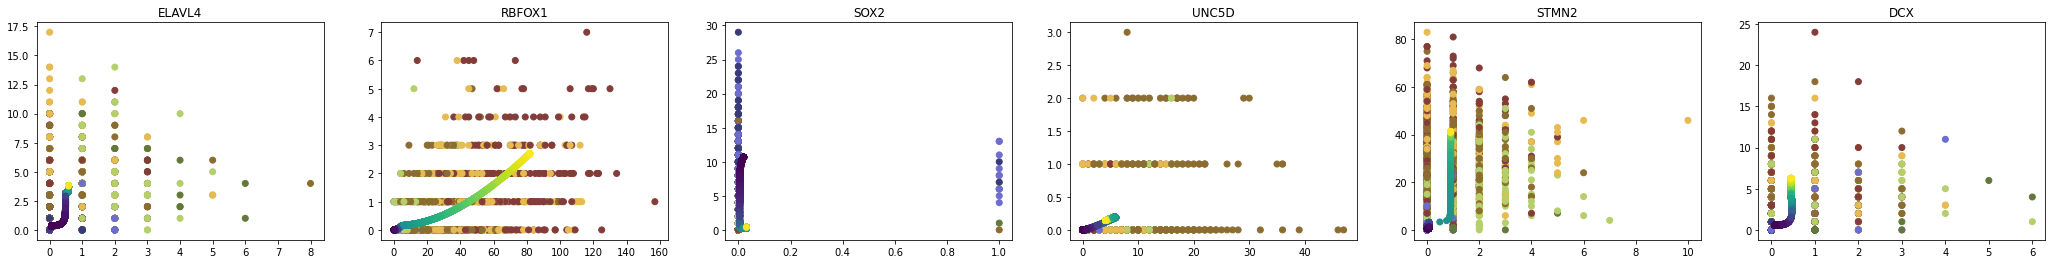

In [37]:
plot_phase(X[:,plot_idx],theta_hat_4[plot_idx], weight_4, tau, gene_list[plot_idx])

In [32]:
plot_idx=np.zeros(len(gene_list),dtype=bool)
plot_idx[:1]=1

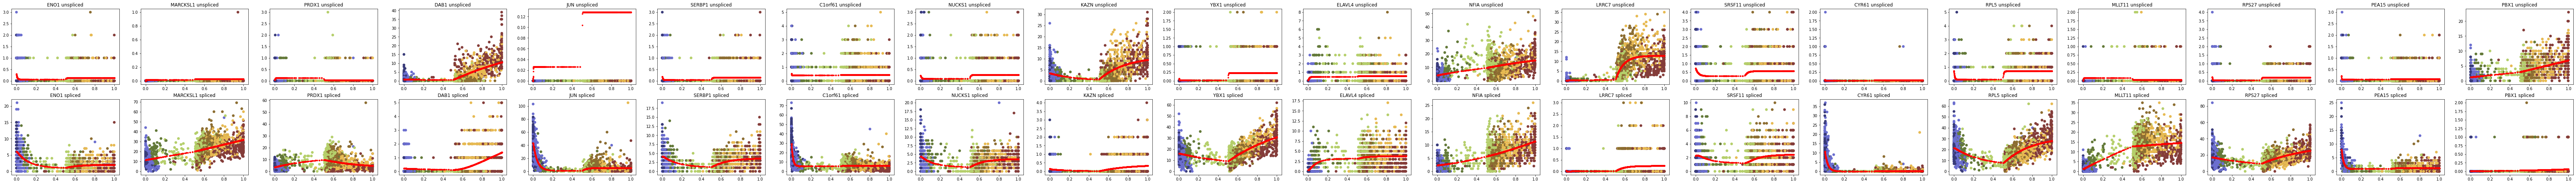

In [33]:
plot_y(X[:,plot_idx,:],theta_hat_4[plot_idx,:], weight_4, tau, gene_list[plot_idx])

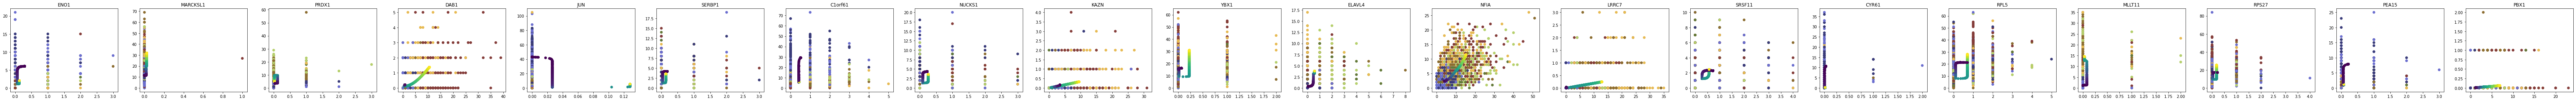

In [34]:
plot_phase(X[:,plot_idx],theta_hat_4[plot_idx], weight_4, tau, gene_list[plot_idx])

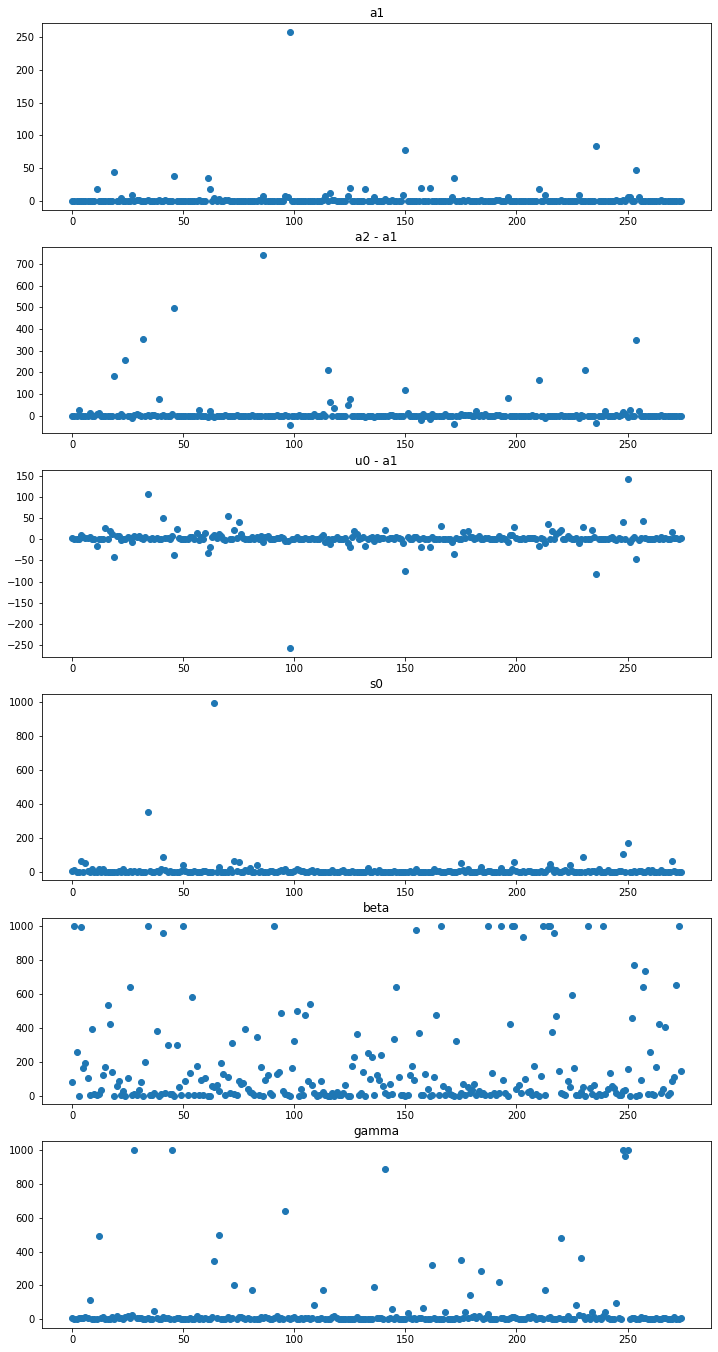

In [131]:
plot_theta_hat(theta_hat_4, len(tau)-1)

In [140]:
weird = np.where(theta_hat_4[:,0]>200)[0]
weird

array([98])

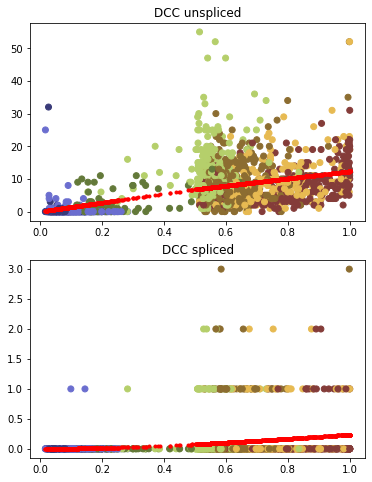

In [141]:
plot_y(X[:,weird,:],theta_hat_4[weird,:], weight_4, tau, gene_list[weird])